In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    RandomizedSearchCV, cross_val_predict
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    cohen_kappa_score, make_scorer, 
    confusion_matrix, f1_score
)

from scipy.stats import randint, loguniform

In [2]:
df = pd.read_csv('cosine_data.csv')
df.head()

,mode_substrt,mode_pool,median_esveg92,median_temp,median_do,median_current,median_depth,median_cond,snag_present,riprap_present,inout_present,flooded_present,cluster
0,2.0,04,3.0,24.8,6.0,0.02,1.60,287.0,1.0,0.0,0.0,1.0,5
1,2.0,04,2.0,28.1,12.8,0.06,0.45,507.0,0.0,0.0,0.0,0.0,4
2,1.0,04,2.0,25.3,7.2,0.04,0.50,561.0,0.0,0.0,0.0,0.0,4
3,1.0,04,1.0,26.7,5.8,0.02,0.60,327.0,1.0,0.0,1.0,0.0,4
4,2.0,04,1.0,21.7,7.3,0.03,0.90,470.0,0.0,0.0,1.0,0.0,4


In [3]:
X = df.drop(columns = ['cluster'])
y = df['cluster'] 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [5]:
cat_cols = ['mode_pool', 'snag_present', 'riprap_present', 'inout_present', 'flooded_present', 'snag_present', 'mode_substrt']
num_cols = ['median_esveg92', 'median_temp', 'median_do', 'median_current', 'median_depth', 'median_cond']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [6]:
ohe = OneHotEncoder(drop = 'first', sparse_output = False).set_output(transform = 'pandas')
X_train = X_train.join(ohe.fit_transform(X_train[['mode_substrt', 'mode_pool']]))
X_test = X_test.join(ohe.transform(X_test[['mode_substrt', 'mode_pool']]))

X_train.drop(columns = ['mode_substrt', 'mode_pool'], inplace=True)
X_test.drop(columns = ['mode_substrt', 'mode_pool'], inplace=True)

In [7]:
param_dist = {
    'max_depth': [None, 3, 5, 7, 10, 15, 20],
    'min_samples_split': randint(2, 51),  # random int between 2 and 50
    'min_samples_leaf': randint(1, 21),   # added for better regularization
    'min_impurity_decrease': loguniform(1e-4, 1e-1),  # better spread across orders of magnitude
    'ccp_alpha': loguniform(1e-5, 1.0)  # covers a wide but meaningful range
}

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [8]:
best_estimators = {}
cv_predictions = {}
conf_matrices = {}

# Loop through classes 1 to 5
for i in range(1, 6):
    print(i)
    y_binary = (y_train == i)  # One-vs-rest for class i

    search = RandomizedSearchCV(
        estimator=DecisionTreeClassifier(class_weight="balanced"),
        param_distributions=param_dist,
        n_iter=500,
        scoring=make_scorer(f1_score),
        cv=stratified_kfold,
        random_state=42,
        n_jobs = -1
    )
    search.fit(X_train, y_binary)

    best_model = search.best_estimator_
    preds = cross_val_predict(best_model, X_train, y_binary, cv=10, method='predict_proba')[:, 1] # cross_val_predict(best_model, X_train, y_binary, cv=5)

    best_estimators[f'clf_{i}'] = best_model
    cv_predictions[f'clf_{i}'] = preds
    #conf_matrices[f'clf_{i}'] = confusion_matrix(y_binary, preds)

1
2
3
4
5


In [9]:
X_train_meta = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(cv_predictions).reset_index(drop=True)], axis=1)
X_train_meta

,median_esveg92,median_temp,median_do,median_current,median_depth,median_cond,snag_present,riprap_present,inout_present,flooded_present,...,mode_substrt_4.0,mode_pool_08,mode_pool_13,mode_pool_26,mode_pool_LG,clf_1,clf_2,clf_3,clf_4,clf_5
0,-0.947211,1.211016,2.714891,-0.191202,1.624004,2.750552,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.963861,0.005510,0.011196,0.104478,0.166259
1,1.545675,0.898816,0.940226,-0.493441,-0.203301,-0.701565,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.017423,0.435715,0.115639,0.795100,0.856397
2,-0.947211,1.176327,0.940226,-0.291948,1.167178,0.298308,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.963861,0.005510,0.011196,0.104478,0.166259
3,0.714713,-0.037783,-0.079263,1.722978,-0.051025,0.327502,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.017423,0.380330,0.911345,0.000000,0.166259
4,0.714713,-0.245916,-1.098752,-0.493441,0.253526,-0.694266,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.017423,0.934020,0.661939,0.066148,0.166259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,1.545675,0.933505,1.733162,-0.392694,1.319453,-0.256366,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.017249,0.930538,0.046778,0.041954,0.158421
1347,-0.947211,-2.604758,0.524879,0.715515,-0.660127,-2.124742,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.965107,0.326199,0.373888,0.000000,0.158421
1348,-0.116249,1.575249,2.979203,-0.493441,-0.660127,0.196132,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.000000,0.050561,0.046778,0.000000,0.158421
1349,0.714713,-2.119114,0.034014,0.211783,-0.051025,-0.329349,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.017249,0.930538,0.925134,0.041954,0.158421


In [10]:
search_meta = RandomizedSearchCV(
        estimator=DecisionTreeClassifier(class_weight="balanced"),
        param_distributions=param_dist,
        n_iter=500,
        scoring=make_scorer(cohen_kappa_score),
        cv=stratified_kfold,
        random_state=42,
        n_jobs = -1
)

search_meta.fit(X_train_meta, y_train)

,estimator,DecisionTreeC...ht='balanced')
,param_distributions,"{'ccp_alpha': <scipy.stats....t 0x13e337130>, 'max_depth': [None, 3, ...], 'min_impurity_decrease': <scipy.stats....t 0x13e337280>, 'min_samples_leaf': <scipy.stats....t 0x13e334f10>, ...}"
,n_iter,500
,scoring,make_scorer(c...hod='predict')
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [11]:
pd.DataFrame(search_meta.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
397,0.005764,0.002109,0.002182,0.001616,0.004622,10,0.002347,6,3,"{'ccp_alpha': 0.0046215635868714355, 'max_dept...",...,0.671944,0.672354,0.730360,0.716812,0.710343,0.740365,0.653465,0.693445,0.031391,1
29,0.005578,0.001973,0.002030,0.001302,0.001209,15,0.004150,7,34,"{'ccp_alpha': 0.00120934368004333, 'max_depth'...",...,0.672161,0.663070,0.719855,0.747248,0.710343,0.740365,0.662599,0.693443,0.037127,2
378,0.005122,0.001908,0.001431,0.000826,0.001169,None,0.003694,7,32,"{'ccp_alpha': 0.0011688142764232313, 'max_dept...",...,0.680757,0.663070,0.719855,0.746888,0.719813,0.740365,0.662599,0.693396,0.040920,3
216,0.004804,0.001689,0.001762,0.001166,0.000078,None,0.004679,8,35,"{'ccp_alpha': 7.811299868262493e-05, 'max_dept...",...,0.672161,0.663440,0.730360,0.747248,0.701504,0.740365,0.653592,0.692720,0.038536,4
376,0.004443,0.001671,0.001960,0.002688,0.000344,20,0.003952,8,17,"{'ccp_alpha': 0.0003439139756527846, 'max_dept...",...,0.672161,0.672354,0.719855,0.736862,0.701548,0.740365,0.662599,0.690636,0.038574,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.007101,0.002476,0.001909,0.001201,0.582585,10,0.001926,3,34,"{'ccp_alpha': 0.5825849149538054, 'max_depth':...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427
332,0.003555,0.001960,0.001461,0.000901,0.232871,3,0.023926,7,43,"{'ccp_alpha': 0.2328714194573258, 'max_depth':...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427
333,0.002839,0.001142,0.001248,0.001046,0.913412,3,0.054587,12,4,"{'ccp_alpha': 0.9134117241167591, 'max_depth':...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427
336,0.005821,0.001631,0.001599,0.000877,0.719408,20,0.001734,6,46,"{'ccp_alpha': 0.7194083432823464, 'max_depth':...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427


In [20]:
for i in range(1, 6):
    clf = best_estimators[f'clf_{i}']
    X_test[f'clf_{i}'] = clf.predict_proba(X_test[X_train.columns])[:, 1]

In [21]:
y_pred = search_meta.best_estimator_.predict(X_test)

In [22]:
cohen_kappa_score(y_test, y_pred)

0.6670028852243672

In [23]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[125,   0,   1,   5,   1],
       [  1,  55,  24,  10,   2],
       [  0,  11,  30,   5,   0],
       [  1,   2,   3,  31,   3],
       [  0,   2,   3,  10,  13]], dtype=int64)

In [36]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


In [37]:
clf_meta = search_meta.best_estimator_

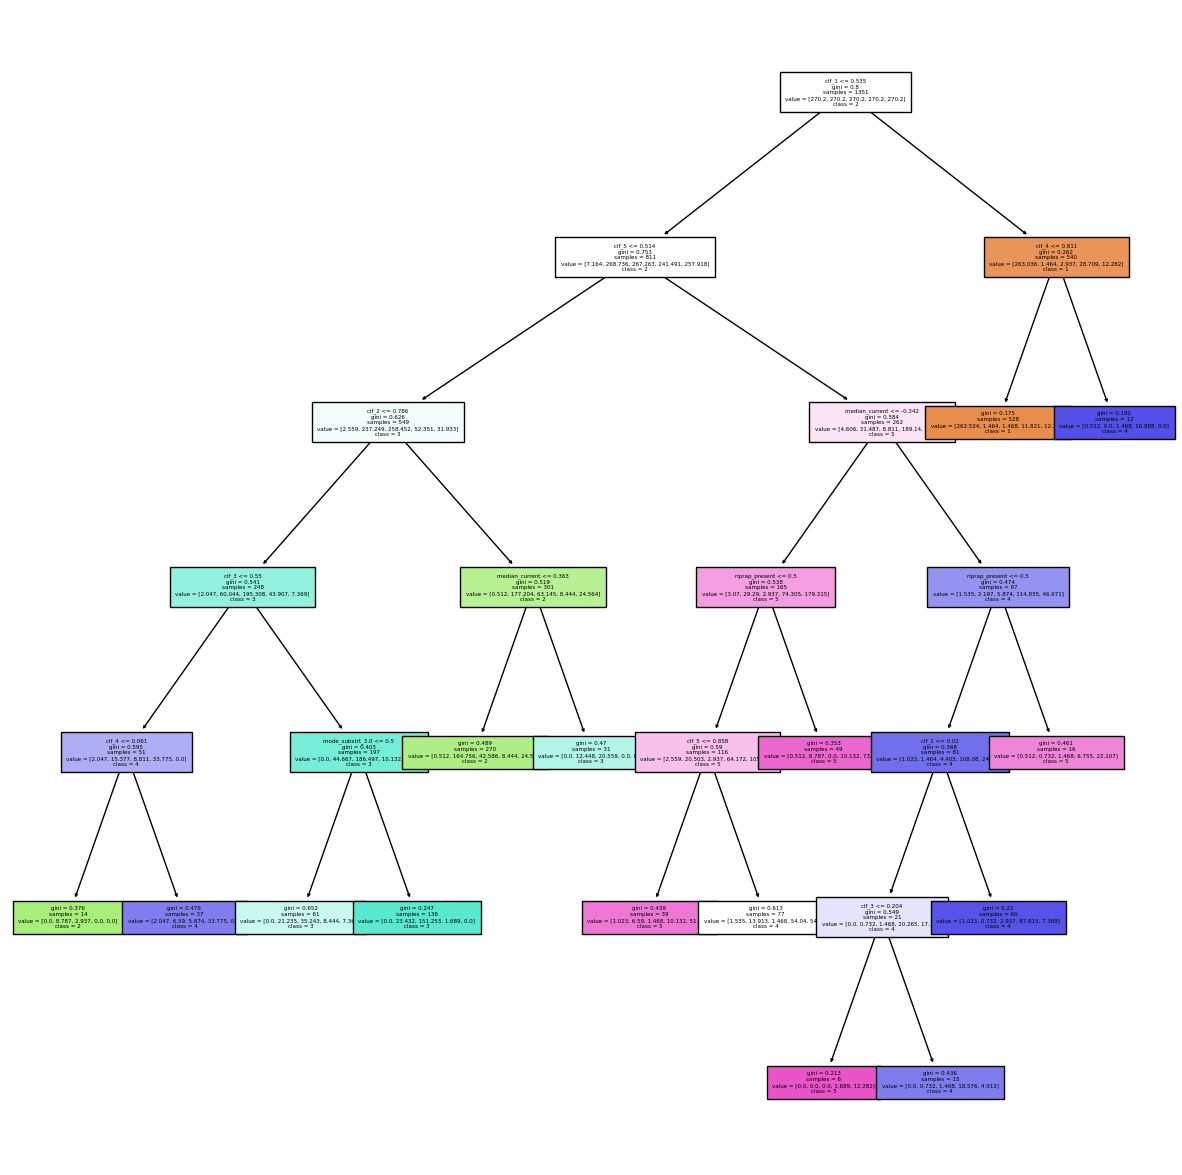

In [58]:
plt.figure(figsize=(15, 15))
plot_tree(clf_meta, filled=True, feature_names=X_train_meta.columns, class_names=[str(s) for s in clf_meta.classes_], fontsize=4)
plt.show()

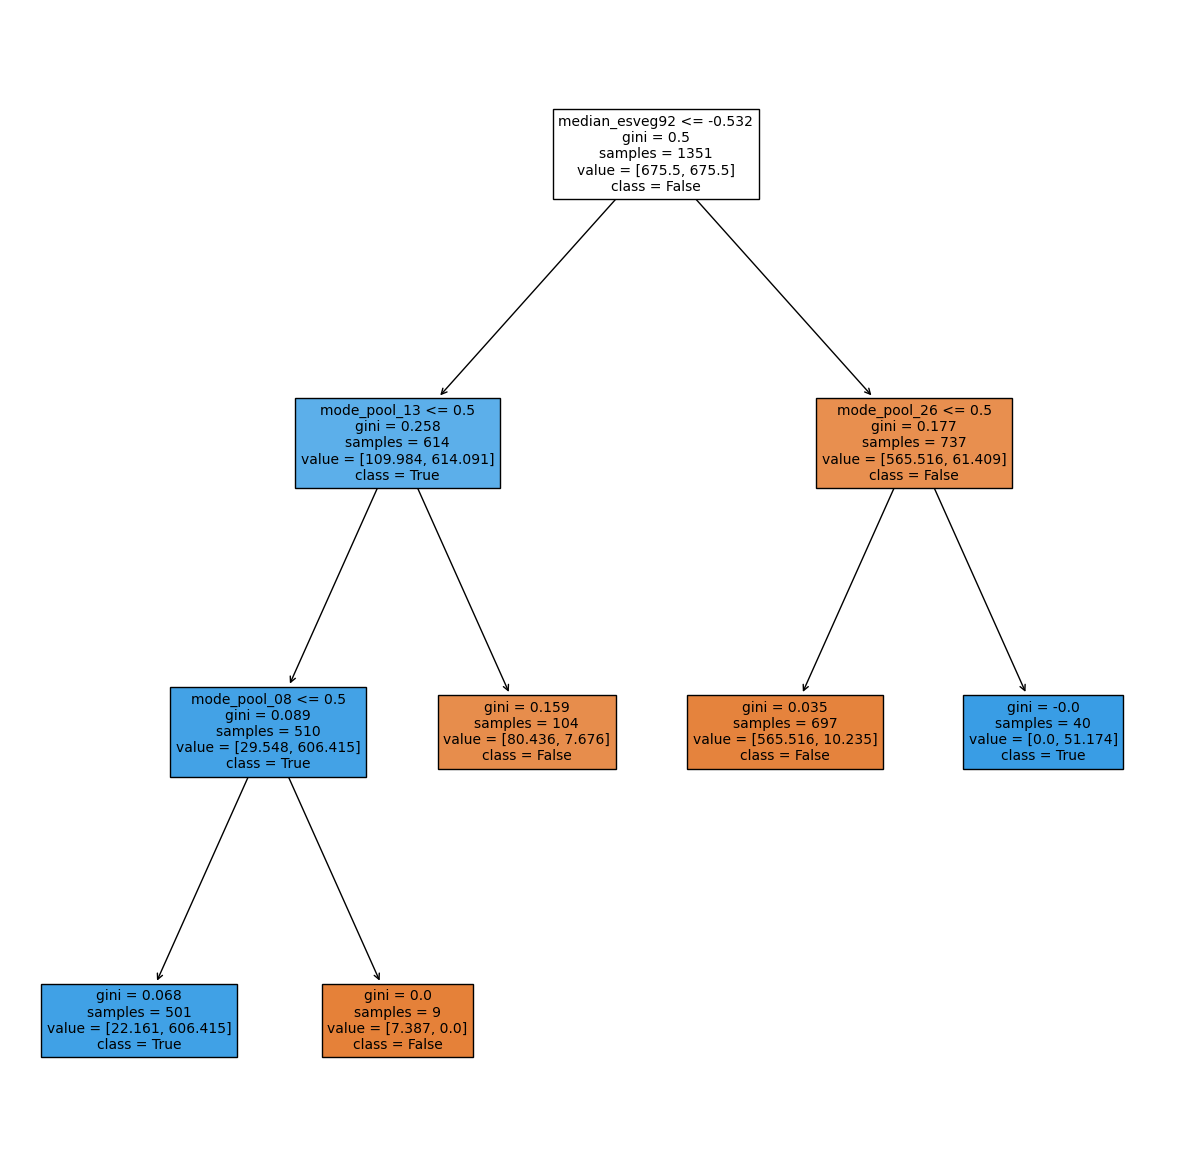

In [60]:
plt.figure(figsize=(15, 15))
plot_tree(best_estimators['clf_1'], filled=True, feature_names=X_train.columns, class_names=[str(s) for s in best_estimators['clf_1'].classes_], fontsize=10)
plt.show()

In [46]:
best_estimators['clf_1']

DecisionTreeClassifier(ccp_alpha=0.002461331530763672, class_weight='balanced',
                       max_depth=7, min_impurity_decrease=0.000254389315925977,
                       min_samples_leaf=4, min_samples_split=46)

In [53]:
X_train

,median_esveg92,median_temp,median_do,median_current,median_depth,median_cond,snag_present,riprap_present,inout_present,flooded_present,mode_substrt_2.0,mode_substrt_3.0,mode_substrt_4.0,mode_pool_08,mode_pool_13,mode_pool_26,mode_pool_LG
1684,-0.947211,1.211016,2.714891,-0.191202,1.624004,2.750552,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1310,1.545675,0.898816,0.940226,-0.493441,-0.203301,-0.701565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1423,-0.947211,1.176327,0.940226,-0.291948,1.167178,0.298308,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
562,0.714713,-0.037783,-0.079263,1.722978,-0.051025,0.327502,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
674,0.714713,-0.245916,-1.098752,-0.493441,0.253526,-0.694266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,1.545675,0.933505,1.733162,-0.392694,1.319453,-0.256366,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282,-0.947211,-2.604758,0.524879,0.715515,-0.660127,-2.124742,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1272,-0.116249,1.575249,2.979203,-0.493441,-0.660127,0.196132,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
428,0.714713,-2.119114,0.034014,0.211783,-0.051025,-0.329349,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
"T